In [23]:
# =============================================================================
#cell 1 通用数据预处理部分
# =============================================================================
import jieba
import jieba.analyse
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# 加载停用词
stopwords = set()
with open("stopwords.txt", "r", encoding="utf-8") as f:
    for line in f:
        stopwords.add(line.strip())

# 加载数据函数
def load_data(filepath):
    data, labels = [], []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) == 3:
                data.append(parts[2])
                labels.append(int(parts[1]))
    return data, labels

# 文本预处理：分词 + 去停用词 + TextRank关键词
def preprocess_data(data, use_textrank=True):
    seg_data = []
    textrank_data = []
    for text in data:
        seg_list = [word for word in jieba.cut(text) if word not in stopwords]
        seg_data.append(" ".join(seg_list))

        if use_textrank:
            keywords = " ".join(jieba.analyse.textrank(text, topK=5, withWeight=False))
            textrank_data.append(keywords)
        else:
            textrank_data.append("")
    return seg_data, textrank_data

# 读取训练与测试数据
train_data, train_labels = load_data("train.txt")
test_data, test_labels = load_data("test.txt")

# 预处理
train_seg, train_textrank = preprocess_data(train_data, use_textrank=True)
test_seg, test_textrank = preprocess_data(test_data, use_textrank=True)

# 合并 TF-IDF 与 TextRank 特征文本
combined_train_features = [seg + " " + textrank for seg, textrank in zip(train_seg, train_textrank)]
combined_test_features = [seg + " " + textrank for seg, textrank in zip(test_seg, test_textrank)]

# 向量化
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(combined_train_features)
test_features = vectorizer.transform(combined_test_features)

# 特征选择（卡方）
selector = SelectKBest(chi2, k=20)
train_features_selected = selector.fit_transform(train_features, train_labels)
test_features_selected = selector.transform(test_features)

# 打印选中特征词
feature_words = [vectorizer.get_feature_names_out()[idx] for idx in selector.get_support(indices=True)]
print("选中特征词：", feature_words)

# 供后续 Cell 使用的全局变量：
# train_features_selected, test_features_selected, train_labels, test_labels, feature_words


选中特征词： ['cnmd', 'doge', 'mmp', 'sb', '伤心', '分手', '去死吧', '可爱', '呵呵', '哈哈哈', '哈哈哈哈', '哭哭', '失望', '微笑', '心碎', '恶心', '拜拜', '摊手', '草泥马', '难受']


In [24]:
# =============================================================================
# Cell 2: 逻辑回归 (Scikit-learn 标准实现)
# =============================================================================

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 模型配置与训练

lr_model = LogisticRegression(
    max_iter=1000, 
    penalty='l2', 
    solver='liblinear', 
    random_state=42
)
lr_model.fit(train_features_selected, np.array(train_labels))

# 2. 模型推理

# 获取预测类别和正类概率
lr_pred = lr_model.predict(test_features_selected)
lr_proba = lr_model.predict_proba(test_features_selected)[:, 1]

# 3. 指标计算

precision = precision_score(test_labels, lr_pred)
recall = recall_score(test_labels, lr_pred)
f1 = f1_score(test_labels, lr_pred)

# 4. 结果输出

print("=" * 40)
print(f"【模型 1】Scikit-learn 逻辑回归")
print("-" * 40)
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("=" * 40)


【模型 1】Scikit-learn 逻辑回归
----------------------------------------
Precision : 0.6221
Recall    : 0.9768
F1 Score  : 0.7601


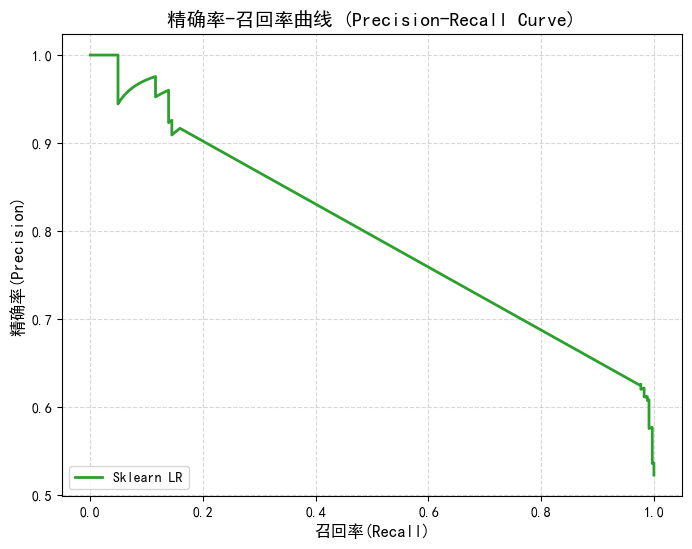

PR 曲线已保存至: ./result/11_pr_curve.png


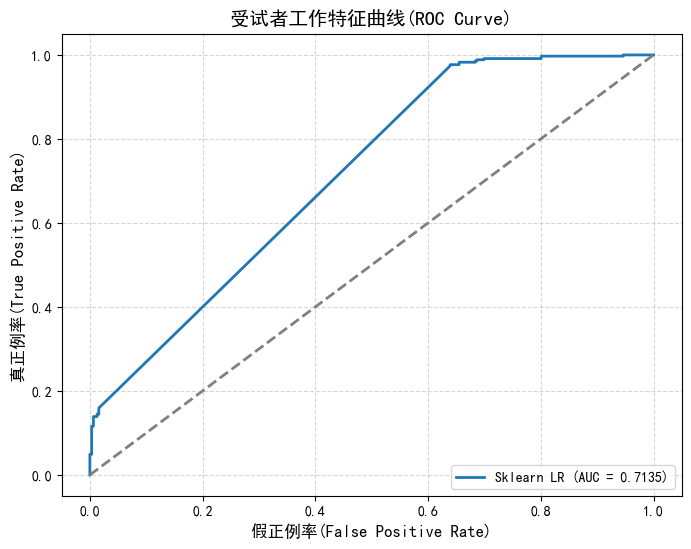

ROC 曲线已保存至: ./result/11_roc_curve.png


In [32]:
# =============================================================================
# Cell 2.5: 绘制并保存 PR 曲线与 ROC 曲线 (Sklearn LR)
# =============================================================================

import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# 确保保存目录存在
if not os.path.exists('./result/'):
    os.makedirs('./result/')

# -----------------------------------------------------------------------------
# 1. 绘制 Precision-Recall 曲线
# -----------------------------------------------------------------------------
precision, recall, _ = precision_recall_curve(test_labels, lr_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#2ca02c', lw=2, label='Sklearn LR')
plt.xlabel('召回率(Recall)', fontsize=12)
plt.ylabel('精确率(Precision)', fontsize=12)
plt.title('精确率-召回率曲线 (Precision-Recall Curve)', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)

# 保存图片
save_path_pr = './result/11_pr_curve.png'
plt.savefig(save_path_pr, dpi=300, bbox_inches='tight')
plt.show()
print(f"PR 曲线已保存至: {save_path_pr}")

# -----------------------------------------------------------------------------
# 2. 绘制 ROC 曲线
# -----------------------------------------------------------------------------
fpr, tpr, _ = roc_curve(test_labels, lr_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'Sklearn LR (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # 对角线
plt.xlabel('假正例率(False Positive Rate)', fontsize=12)
plt.ylabel('真正例率(True Positive Rate)', fontsize=12)
plt.title('受试者工作特征曲线(ROC Curve)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)

# 保存图片
save_path_roc = './result/11_roc_curve.png'
plt.savefig(save_path_roc, dpi=300, bbox_inches='tight')
plt.show()
print(f"ROC 曲线已保存至: {save_path_roc}")


In [26]:
# Cell 3: 自编写逻辑回归 (基础梯度下降 BGD)


import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 数据准备
# -----------------------------------------------------------------------------
# 将稀疏矩阵转换为稠密数组以进行矩阵运算
X_train = train_features_selected.toarray()
X_test = test_features_selected.toarray()
y_train = np.array(train_labels, dtype=np.float64)
y_test = np.array(test_labels, dtype=np.float64)

# 2. 模型定义
# -----------------------------------------------------------------------------
class ManualLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, reg_lambda=1.0, verbose=False):
        self.lr = learning_rate
        self.max_iter = max_iter
        self.reg_lambda = reg_lambda
        self.verbose = verbose
        self.w = None
        self.b = 0.0

    def _sigmoid(self, z):
        # 数值稳定性处理：防止 exp 溢出
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        # 初始化参数（零初始化）
        self.w = np.zeros(n, dtype=np.float64)
        self.b = 0.0

        for i in range(self.max_iter):
            # 前向传播
            z = X.dot(self.w) + self.b
            h = self._sigmoid(z)

            # 梯度计算 (含 L2 正则化导数)
            error = h - y
            dw = (1.0 / m) * (X.T.dot(error)) + (self.reg_lambda / m) * self.w
            db = (1.0 / m) * np.sum(error)

            # 参数更新
            self.w -= self.lr * dw
            self.b -= self.lr * db

            # 打印日志
            if self.verbose and i % 200 == 0:
                loss = (-1.0/m) * np.sum(y * np.log(h + 1e-9) + (1 - y) * np.log(1 - h + 1e-9))
                print(f"Iter {i}: Loss = {loss:.6f}")

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# 3. 模型训练与推理
# -----------------------------------------------------------------------------
manual_lr = ManualLogisticRegression(
    learning_rate=0.1, 
    max_iter=1000, 
    reg_lambda=1.0, 
    verbose=False
)
manual_lr.fit(X_train, y_train)

manual_pred = manual_lr.predict(X_test)

# 4. 结果输出
# -----------------------------------------------------------------------------
precision = precision_score(y_test, manual_pred)
recall = recall_score(y_test, manual_pred)
f1 = f1_score(y_test, manual_pred)

print("=" * 40)
print(f"【模型 2】自编写逻辑回归 (Basic GD)")
print("-" * 40)
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("=" * 40)


【模型 2】自编写逻辑回归 (Basic GD)
----------------------------------------
Precision : 0.5255
Recall    : 1.0000
F1 Score  : 0.6889


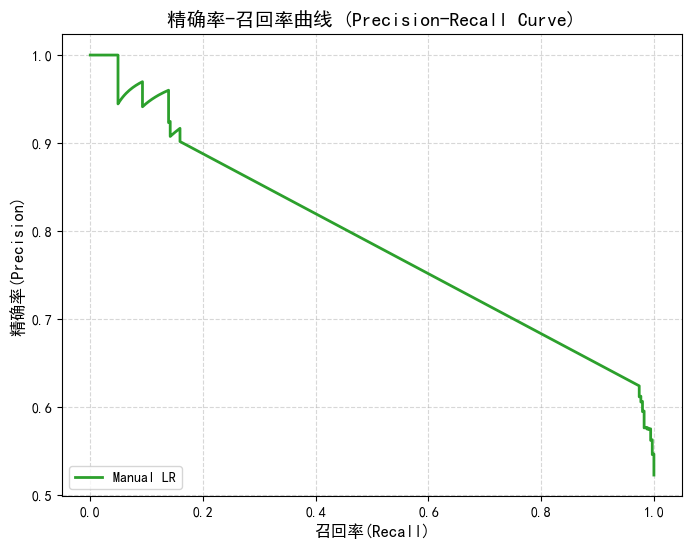

PR 曲线已保存至: ./result/12_pr_curve.png


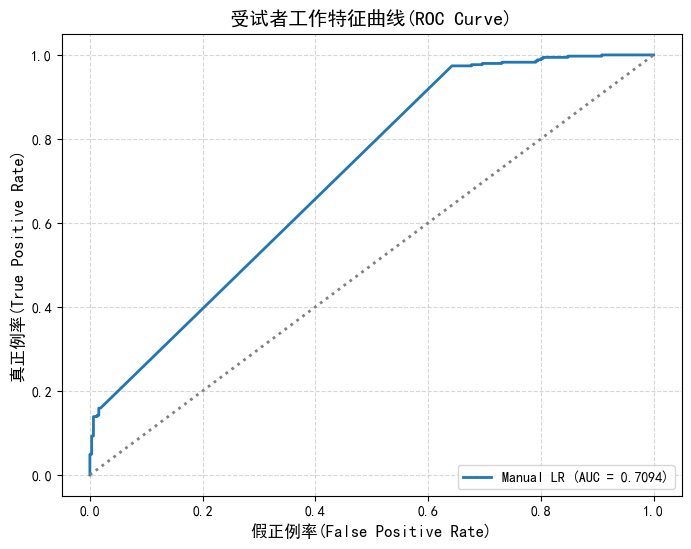

ROC 曲线已保存至: ./result/12_roc_curve.png


In [33]:
# =============================================================================
# Cell 3.5: 绘制并保存 PR 曲线与 ROC 曲线 (Manual LR)
# =============================================================================

import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# 确保保存目录存在
if not os.path.exists('./result/'):
    os.makedirs('./result/')

# 1. 获取预测概率
# -----------------------------------------------------------------------------
# 自编写模型 predict_proba 返回的是正类(1)的概率值
manual_proba = manual_lr.predict_proba(X_test)

# 2. 绘制 Precision-Recall 曲线
# -----------------------------------------------------------------------------
precision, recall, _ = precision_recall_curve(y_test, manual_proba)

plt.figure(figsize=(8, 6))
# 使用虚线表示手写版本，颜色保持绿色系但稍深
plt.plot(recall, precision, color='#2ca02c', lw=2, label='Manual LR')
plt.xlabel('召回率(Recall)', fontsize=12)
plt.ylabel('精确率(Precision)', fontsize=12)
plt.title('精确率-召回率曲线 (Precision-Recall Curve)', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)

# 保存图片 (命名为 12 以区别于模型 1)
save_path_pr = './result/12_pr_curve.png'
plt.savefig(save_path_pr, dpi=300, bbox_inches='tight')
plt.show()
print(f"PR 曲线已保存至: {save_path_pr}")

# 3. 绘制 ROC 曲线
# -----------------------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, manual_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'Manual LR (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':') # 对角线
plt.xlabel('假正例率(False Positive Rate)', fontsize=12)
plt.ylabel('真正例率(True Positive Rate)', fontsize=12)
plt.title('受试者工作特征曲线(ROC Curve)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)

# 保存图片 (命名为 12 以区别于模型 1)
save_path_roc = './result/12_roc_curve.png'
plt.savefig(save_path_roc, dpi=300, bbox_inches='tight')
plt.show()
print(f"ROC 曲线已保存至: {save_path_roc}")


In [28]:
# =============================================================================
# Cell 4: 优化逻辑回归 (Adam 优化器 + ElasticNet 正则化)
# =============================================================================

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 模型定义
# -----------------------------------------------------------------------------
class OptimizedLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, batch_size=32, 
                 alpha=0.0001, l1_ratio=0.5, verbose=False):
        self.lr = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.alpha = alpha        # 正则化强度
        self.l1_ratio = l1_ratio  # L1/L2 混合比例
        self.verbose = verbose
        self.w = None
        self.b = 0.0
        self.loss_history = []

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        
        # 参数初始化：使用随机小值打破对称性
        np.random.seed(42)
        self.w = np.random.randn(n) * 0.01
        self.b = 0.0
        
        # Adam 优化器参数初始化
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8
        mw, vw = np.zeros(n), np.zeros(n)  # 权重的一阶/二阶矩
        mb, vb = 0.0, 0.0                  # 偏置的一阶/二阶矩
        t = 0 

        for epoch in range(self.max_iter):
            # 数据混洗 (Shuffle)
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y[indices]

            # Mini-Batch 迭代
            for start_idx in range(0, m, self.batch_size):
                t += 1
                end_idx = min(start_idx + self.batch_size, m)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                curr_m = len(y_batch)

                # 前向传播
                z = X_batch.dot(self.w) + self.b
                h = self._sigmoid(z)

                # 基础梯度计算
                error = h - y_batch
                grad_w = (1.0 / curr_m) * X_batch.T.dot(error)
                grad_b = (1.0 / curr_m) * np.sum(error)

                # 添加 ElasticNet 正则化梯度项
                l2_grad = self.alpha * (1 - self.l1_ratio) * self.w
                l1_grad = self.alpha * self.l1_ratio * np.sign(self.w)
                grad_w += (l2_grad + l1_grad)

                # Adam 参数更新：权重 w
                mw = beta1 * mw + (1 - beta1) * grad_w
                vw = beta2 * vw + (1 - beta2) * (grad_w ** 2)
                mw_hat = mw / (1 - beta1 ** t)
                vw_hat = vw / (1 - beta2 ** t)
                self.w -= self.lr * mw_hat / (np.sqrt(vw_hat) + epsilon)

                # Adam 参数更新：偏置 b
                mb = beta1 * mb + (1 - beta1) * grad_b
                vb = beta2 * vb + (1 - beta2) * (grad_b ** 2)
                mb_hat = mb / (1 - beta1 ** t)
                vb_hat = vb / (1 - beta2 ** t)
                self.b -= self.lr * mb_hat / (np.sqrt(vb_hat) + epsilon)

            # 日志记录
            if self.verbose and (epoch % 50 == 0):
                z_full = X.dot(self.w) + self.b
                h_full = self._sigmoid(z_full)
                loss = -np.mean(y * np.log(h_full + 1e-9) + (1 - y) * np.log(1 - h_full + 1e-9))
                self.loss_history.append(loss)
                #print(f"Epoch {epoch}: Loss = {loss:.6f}")

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# 2. 模型训练与推理
# -----------------------------------------------------------------------------

# 配置优化后的超参数
opt_model = OptimizedLogisticRegression(
    learning_rate=0.01,
    max_iter=500,
    batch_size=32,
    alpha=0.0001,
    l1_ratio=0.6,
    verbose=True
)
opt_model.fit(X_train, y_train)

# 3. 预测与评估 (包含阈值调整策略)
# -----------------------------------------------------------------------------
# 提升阈值至 0.5 以优化 Precision
target_threshold = 0.5 
opt_pred = opt_model.predict(X_test, threshold=target_threshold)

precision = precision_score(y_test, opt_pred)
recall = recall_score(y_test, opt_pred)
f1 = f1_score(y_test, opt_pred)

# 4. 结果输出
# -----------------------------------------------------------------------------
print("=" * 40)
print(f"【模型 3】优化逻辑回归 (Adam + ElasticNet)")
print("-" * 40)
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("=" * 40)


【模型 3】优化逻辑回归 (Adam + ElasticNet)
----------------------------------------
Precision : 0.6256
Recall    : 0.9768
F1 Score  : 0.7627


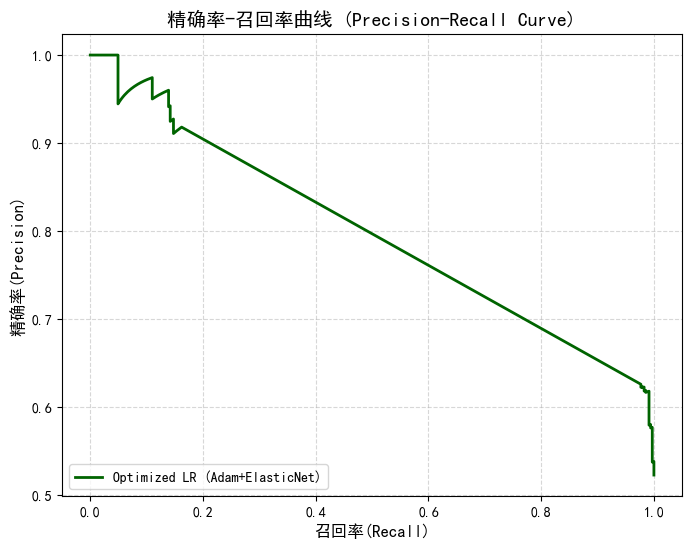

PR 曲线已保存至: ./result/13_pr_curve.png


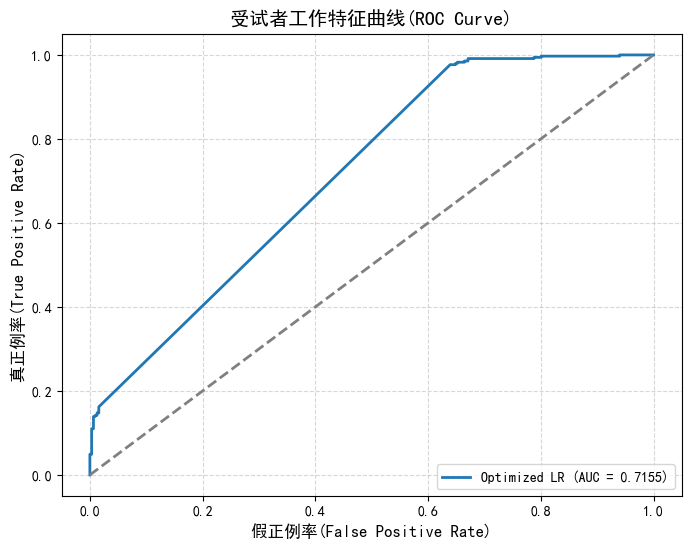

ROC 曲线已保存至: ./result/13_roc_curve.png


In [34]:
# =============================================================================
# Cell 4.5: 绘制并保存 PR 曲线与 ROC 曲线 (Optimized LR)
# =============================================================================

import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# 确保保存目录存在
if not os.path.exists('./result/'):
    os.makedirs('./result/')

# 1. 获取预测概率
# -----------------------------------------------------------------------------
# 使用优化后的模型预测正类概率
opt_proba = opt_model.predict_proba(X_test)

# 2. 绘制 Precision-Recall 曲线
# -----------------------------------------------------------------------------
precision, recall, _ = precision_recall_curve(y_test, opt_proba)

plt.figure(figsize=(8, 6))
# 使用实线加深色，代表“优化版”
plt.plot(recall, precision, color='#006400', lw=2, label='Optimized LR (Adam+ElasticNet)')
plt.xlabel('召回率(Recall)', fontsize=12)
plt.ylabel('精确率(Precision)', fontsize=12)
plt.title('精确率-召回率曲线 (Precision-Recall Curve)', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)

# 保存图片 (命名为 13 以区别于前两个模型)
save_path_pr = './result/13_pr_curve.png'
plt.savefig(save_path_pr, dpi=300, bbox_inches='tight')
plt.show()
print(f"PR 曲线已保存至: {save_path_pr}")

# 3. 绘制 ROC 曲线
# -----------------------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, opt_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'Optimized LR (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('假正例率(False Positive Rate)', fontsize=12)
plt.ylabel('真正例率(True Positive Rate)', fontsize=12)
plt.title('受试者工作特征曲线(ROC Curve)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)

# 保存图片 (命名为 13 以区别于前两个模型)
save_path_roc = './result/13_roc_curve.png'
plt.savefig(save_path_roc, dpi=300, bbox_inches='tight')
plt.show()
print(f"ROC 曲线已保存至: {save_path_roc}")


正在收集各模型预测数据...
绘图完成
图片已保存至: result\1_model_comparison_optimized_view.png
说明: 如果看到红色细线紧密覆盖在绿色宽线之上，
      证明优化后的自编写模型已成功复现了库函数的性能。


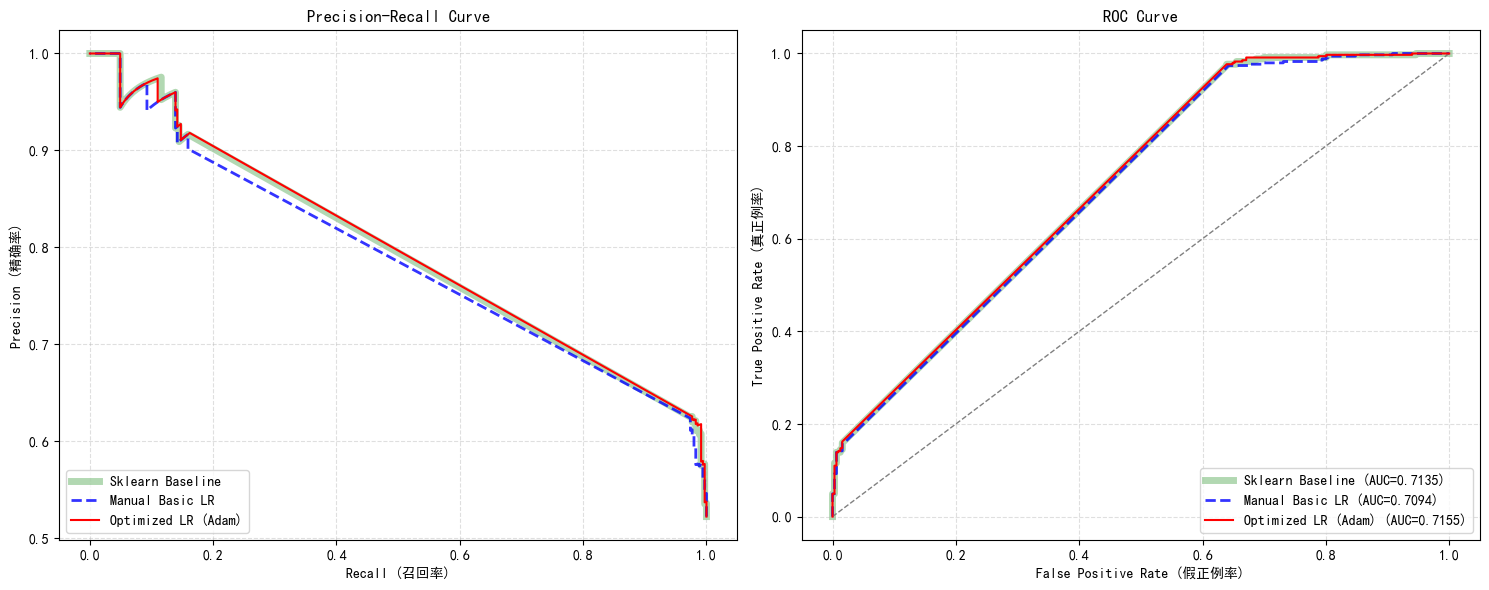

In [30]:
# =============================================================================
# Cell 5: 模型性能对比绘图 (PR曲线与ROC曲线)
# =============================================================================

import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
# 1. 环境与路径配置
# -----------------------------------------------------------------------------
save_dir = 'result'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建结果目录: {save_dir}")

# 2. 获取预测概率数据
# -----------------------------------------------------------------------------
print("正在收集各模型预测数据...")

# (1) 基准模型 (Sklearn Baseline)
#为了确保对比严谨，这里重新快速训练一个标准库模型
sklearn_base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
sklearn_base.fit(train_features_selected, train_labels)
proba_sklearn = sklearn_base.predict_proba(test_features_selected)[:, 1]

# (2) 手写基础模型 (Manual Basic)
# 从全局变量中获取 Cell 3 训练的 manual_lr
if 'manual_lr' in globals():
    proba_manual = manual_lr.predict_proba(X_test)
else:
    print("警告: 未检测到 manual_lr，跳过绘制该模型。")
    proba_manual = None

# (3) 优化模型 (Optimized LR)
# 从全局变量中获取 Cell 4 训练的 opt_model (修复了之前的变量名 opt_lr 问题)
if 'opt_model' in globals():
    proba_opt = opt_model.predict_proba(X_test)

else:
    print("警告: 未检测到 opt_model，跳过绘制该模型。")
    proba_opt = None

# 3. 绘图配置 (视觉分层策略)
# -----------------------------------------------------------------------------
# 格式: (名称, 概率数据, 颜色, 线型, 线宽, 透明度, 图层顺序)
# Zorder 说明: 值越大，图层越靠上 (防止曲线完全重合无法分辨)
plot_configs = [
    # 底层背景: Sklearn (绿色粗线，半透明)
    ("Sklearn Baseline",   proba_sklearn, 'green', '-',  5.0, 0.3, 1),
    
    # 中间层: 手写基础版 (蓝色虚线)
    ("Manual Basic LR",    proba_manual,  'blue',  '--', 2.0, 0.8, 2),
    
    # 最顶层: 优化版 (红色细实线，高亮显示)
    ("Optimized LR (Adam)", proba_opt,    'red',   '-',  1.5, 1.0, 3)
]

# 4. 执行绘图
# -----------------------------------------------------------------------------
plt.figure(figsize=(15, 6))

# --- 子图 1: Precision-Recall Curve (PR曲线) ---
plt.subplot(1, 2, 1)
for name, probs, color, style, lw, alpha, zorder in plot_configs:
    if probs is not None:
        precision, recall, _ = precision_recall_curve(test_labels, probs)
        plt.plot(recall, precision, color=color, linestyle=style, 
                 linewidth=lw, alpha=alpha, zorder=zorder, label=name)

plt.xlabel('Recall (召回率)')
plt.ylabel('Precision (精确率)')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.4)

# --- 子图 2: ROC Curve (ROC曲线) ---
plt.subplot(1, 2, 2)
for name, probs, color, style, lw, alpha, zorder in plot_configs:
    if probs is not None:
        fpr, tpr, _ = roc_curve(test_labels, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, linestyle=style, 
                 linewidth=lw, alpha=alpha, zorder=zorder, 
                 label=f'{name} (AUC={roc_auc:.4f})')

# 绘制对角参考线
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (假正例率)')
plt.ylabel('True Positive Rate (真正例率)')
plt.title('ROC Curve')
plt.legend(loc='lower right', frameon=True)
plt.grid(True, linestyle='--', alpha=0.4)

# 5. 保存与展示
# -----------------------------------------------------------------------------
plt.tight_layout()
save_path = os.path.join(save_dir, '1_model_comparison_optimized_view.png')
plt.savefig(save_path, dpi=300)

print("=" * 40)
print(f"绘图完成")
print(f"图片已保存至: {save_path}")
print("说明: 如果看到红色细线紧密覆盖在绿色宽线之上，")
print("      证明优化后的自编写模型已成功复现了库函数的性能。")
print("=" * 40)
plt.show()


>>> 1. 绘制库函数模型 (Scikit-learn)...


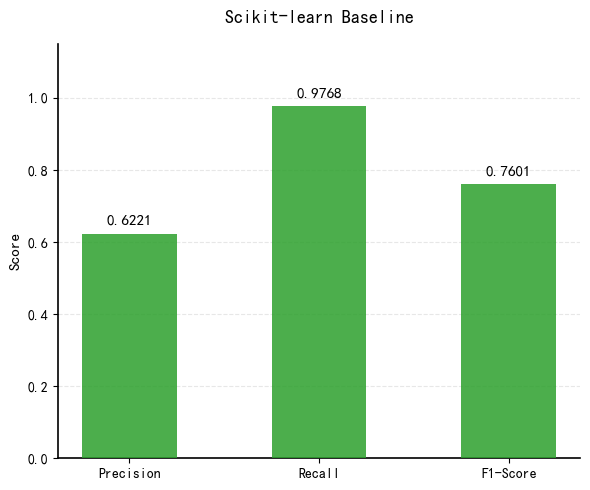

已保存图表: result\bar_1_sklearn.png
>>> 2. 绘制基础自编写模型 (Basic GD)...


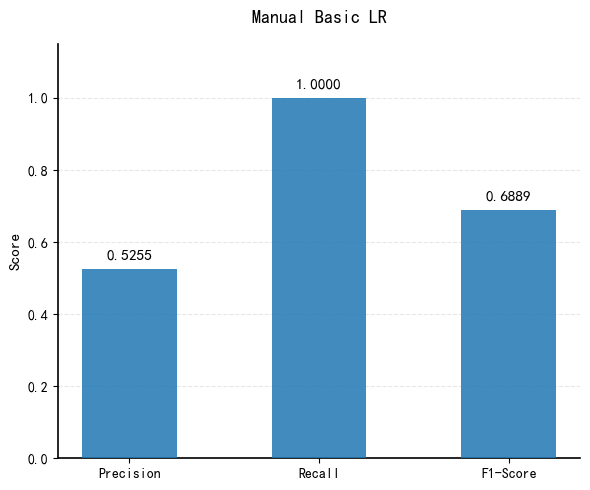

已保存图表: result\bar_2_manual_basic.png
>>> 3. 绘制优化自编写模型 (Adam + ElasticNet)...


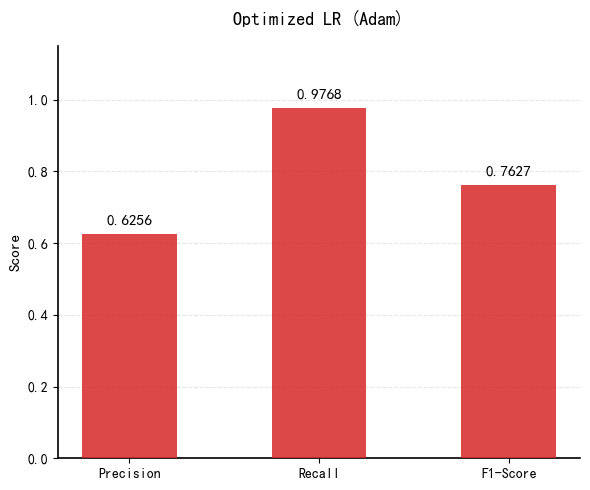

已保存图表: result\bar_3_optimized.png


In [31]:
# =============================================================================
# Cell 6: 模型性能指标柱状图 (基于更新后的变量名)
# =============================================================================

import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 绘图函数定义
# -----------------------------------------------------------------------------
def plot_single_model_bar(model_name, precision, recall, f1, color, file_name):
    """
    绘制单个模型的性能指标柱状图
    """
    # 数据准备
    metrics = [precision, recall, f1]
    labels = ['Precision', 'Recall', 'F1-Score']
    
    # 创建画布
    plt.figure(figsize=(6, 5))
    
    # 绘制柱状图
    bars = plt.bar(labels, metrics, color=color, width=0.5, alpha=0.85, zorder=3)
    
    # 添加数值标签 (柱顶显示)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

    # 图表美化
    plt.title(model_name, fontsize=13, fontweight='bold', pad=15)
    plt.ylim(0, 1.15)  # Y轴稍微留白
    plt.ylabel('Score', fontsize=11)
    
    # 设置网格与边框
    plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    # 保存图片
    save_dir = 'result'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    save_path = os.path.join(save_dir, file_name)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"已保存图表: {save_path}")

# 2. 获取数据并绘图
# -----------------------------------------------------------------------------
# 注意：这里直接使用 Cell 2/3/4 生成的全局预测变量 (lr_pred, manual_pred, opt_pred)
# 这样可以避免因 Cell 内部临时变量名(precision/recall)重复而被覆盖的问题

# --- (1) Scikit-learn 基准模型 (绿色) ---
if 'lr_pred' in globals() and 'test_labels' in globals():
    p1 = precision_score(test_labels, lr_pred)
    r1 = recall_score(test_labels, lr_pred)
    f1_1 = f1_score(test_labels, lr_pred)
    
    print(">>> 1. 绘制库函数模型 (Scikit-learn)...")
    plot_single_model_bar(
        model_name="Scikit-learn Baseline", 
        precision=p1, recall=r1, f1=f1_1, 
        color='#2ca02c',  # 绿色
        file_name='bar_1_sklearn.png'
    )
else:
    print("警告: 未检测到 lr_pred，跳过模型 1。请先运行 Cell 2。")

# --- (2) 自编写基础模型 (蓝色) ---
if 'manual_pred' in globals() and 'y_test' in globals():
    p2 = precision_score(y_test, manual_pred)
    r2 = recall_score(y_test, manual_pred)
    f1_2 = f1_score(y_test, manual_pred)

    print(">>> 2. 绘制基础自编写模型 (Basic GD)...")
    plot_single_model_bar(
        model_name="Manual Basic LR", 
        precision=p2, recall=r2, f1=f1_2, 
        color='#1f77b4',  # 蓝色
        file_name='bar_2_manual_basic.png'
    )
else:
    print("警告: 未检测到 manual_pred，跳过模型 2。请先运行 Cell 3。")

# --- (3) 自编写优化模型 (红色) ---
if 'opt_pred' in globals() and 'y_test' in globals():
    p3 = precision_score(y_test, opt_pred)
    r3 = recall_score(y_test, opt_pred)
    f1_3 = f1_score(y_test, opt_pred)

    print(">>> 3. 绘制优化自编写模型 (Adam + ElasticNet)...")
    plot_single_model_bar(
        model_name="Optimized LR (Adam)", 
        precision=p3, recall=r3, f1=f1_3, 
        color='#d62728',  # 红色
        file_name='bar_3_optimized.png'
    )
else:
    print("警告: 未检测到 opt_pred，跳过模型 3。请先运行 Cell 4。")
